**To do:**
- Expand dataset
- Expand to multilabel prediction
- Round outputs to nearest decimal -> check performance

## Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
from matplotlib import pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
df = pd.read_excel("WMC_DATA_MSA_DF.xlsx")
df.drop(columns = ["Q1.4", "Q2.4", "Q1.8", "Q2.8", "V1",
                   "Q1_letter_count", "Q2_letter_count",
                   "Q1_word_count", "Q2_word_count", "DataSet "], inplace = True)
df.drop([0], inplace = True)
df["Q1_sum"] = df["Q1.1"] + df["Q1.2"] + df["Q1.3"] + df["Q1.5"] + df["Q1.6"] + df["Q1.7"]
df["Q2_sum"] = df["Q2.1"] + df["Q2.2"] + df["Q2.3"] + df["Q2.5"] + df["Q2.6"] + df["Q2.7"]
df = df.dropna()
df = df[df.Q1_sum >-1]
df = df[df.Q2_sum >-1]

# df_sum = df.copy()
# df_sum.drop(columns = ["Q1.1", "Q1.2", "Q1.3", "Q1.5", "Q1.6", "Q1.7",
#                     "Q2.1", "Q2.2", "Q2.3", "Q2.5", "Q2.6", "Q2.7"], inplace = True)
# df_sum = df_sum.dropna()

In [4]:
df.head()

,Q1,Q2,Q1.1,Q1.2,Q1.3,Q1.5,Q1.6,Q1.7,Q2.1,Q2.2,Q2.3,Q2.5,Q2.6,Q2.7,Q1_sum,Q2_sum
1,"A child and a man, presumably the father, are ...",We are cycling down in the countryside my fath...,1,0,0,0,0,0,7,3,0,0,0,0,1,10
2,Scene opens with a father and daughter riding ...,I imagine she'd be happy to be spending time w...,1,1,0,0,0,0,5,4,0,1,1,0,2,11
5,The clip commences with a cross view of the gi...,"I would imagine she experiences glee at first,...",0,3,1,1,0,0,20,0,1,1,0,0,5,22
6,A girl cycles with her father to see him off a...,The girl seems to be happy to cycle along with...,0,1,1,0,0,0,6,2,0,0,0,0,2,8
7,A father and daughter are cycling through the ...,She is very happy at first because she is goin...,1,0,1,0,0,1,3,0,0,0,0,0,3,3


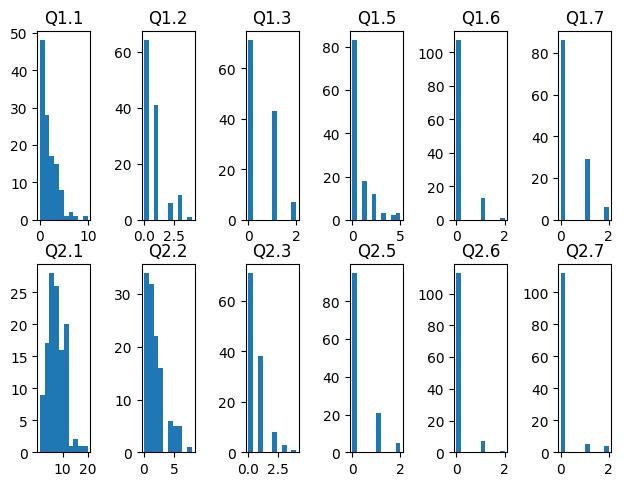

In [5]:
titles1 = ["Q1", "Q2"]
titles2 = [".1", ".2", ".3", ".5", ".6", ".7"]

fig, axs = plt.subplots(2,6)
fig.tight_layout()

for i in range(2):
    for j in range(6):
        name = titles1[i] + titles2[j]
        axs[i,j].hist(df[name])
        axs[i,j].set_title(name)
        

In [6]:
# Use Q1.1 for testing:
trainData = pd.DataFrame()
trainData["text"] = df["Q1"]
trainData["labels"] = df["Q1.1"]
#trainData.labels = trainData.labels.to_numpy()
trainData = trainData.reset_index(drop = True)

trainData.head()

,text,labels
0,"A child and a man, presumably the father, are ...",1
1,Scene opens with a father and daughter riding ...,1
2,The clip commences with a cross view of the gi...,0
3,A girl cycles with her father to see him off a...,0
4,A father and daughter are cycling through the ...,1


## Data Preparation

In [7]:
# Params
# To do: Look into tokenizer params
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [8]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [9]:
# Create dataset
train = MultiLabelDataset(trainData, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train, **train_params)

## Single Attribute Prediction

In [47]:
class nn_single(torch.nn.Module):
    def __init__(self):
        super(nn_single, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.scoreOut = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.scoreOut(pooler)
        return output

model_single = nn_single()

In [48]:
model_single

nn_single(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [68]:
# Training loop
# To do: send tensors to device
EPOCHS = 10
lossVals = []

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-4)

model_single.train()
pass # somehow block cant rerun without this
for i in range(EPOCHS):
    for idx, data in enumerate(training_loader, 0):
        #print(data)
        ids = data['ids']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets']
        targets = targets.reshape(-1,1) # Put in same shape as output

        outputs = model_single(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        lossVals.append(loss.item())

    print("Epoch", i, ":\tLoss:", loss.item())


Epoch 0 :	Loss: 1.1424638032913208
Epoch 1 :	Loss: 1.1839773654937744
Epoch 2 :	Loss: 4.2571001052856445
Epoch 3 :	Loss: 0.016656171530485153
Epoch 4 :	Loss: 0.00677033606916666
Epoch 5 :	Loss: 9.398662567138672
Epoch 6 :	Loss: 0.007699254900217056
Epoch 7 :	Loss: 0.01056528091430664
Epoch 8 :	Loss: 9.460734367370605
Epoch 9 :	Loss: 0.02521519362926483


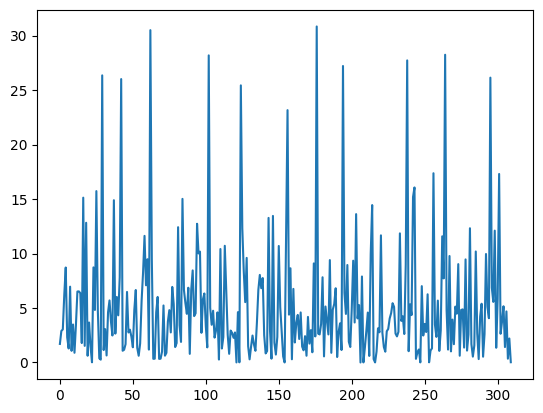

In [69]:
plt.plot(lossVals)

## Multiple Attribute Prediction

In [42]:
# Dataset for Q1
trainDataMulti = pd.DataFrame()
trainDataMulti["text"] = df["Q1"]
trainDataMulti["labels"] = df.iloc[:,2:8].values.tolist()
trainDataMulti = trainDataMulti.reset_index(drop = True)

trainDataMulti.head()

,text,labels
0,"A child and a man, presumably the father, are ...","[1, 0, 0, 0, 0, 0]"
1,Scene opens with a father and daughter riding ...,"[1, 1, 0, 0, 0, 0]"
2,The clip commences with a cross view of the gi...,"[0, 3, 1, 1, 0, 0]"
3,A girl cycles with her father to see him off a...,"[0, 1, 1, 0, 0, 0]"
4,A father and daughter are cycling through the ...,"[1, 0, 1, 0, 0, 1]"


In [43]:
# Create dataset
trainMulti = MultiLabelDataset(trainDataMulti, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader_multi = DataLoader(trainMulti, **train_params)

In [49]:
class nn_multi(torch.nn.Module):
    def __init__(self):
        super(nn_multi, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.scoreOut = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.scoreOut(pooler)
        return output

model_multi = nn_multi()

In [50]:
model_multi

nn_multi(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featur

In [72]:
# Training loop
# To do: send tensors to device
EPOCHS = 10
lossVals = []

loss_fn = torch.nn.MSELoss() # Use MSE since we're doing regression
optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-4)

model_multi.train()
pass # somehow block cant rerun without this
for i in range(EPOCHS):
    for idx, data in enumerate(training_loader_multi, 0):
        #print(data)
        ids = data['ids']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets']

        outputs = model_multi(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        lossVals.append(loss.item())
        
    print("Epoch", i, ":\tLoss:", loss.item())


Epoch 0 :	Loss: 1.6883543729782104
Epoch 1 :	Loss: 0.07742574065923691
Epoch 2 :	Loss: 0.8348169326782227
Epoch 3 :	Loss: 0.20538829267024994
Epoch 4 :	Loss: 1.748218059539795
Epoch 5 :	Loss: 0.15740104019641876
Epoch 6 :	Loss: 0.06644662469625473
Epoch 7 :	Loss: 0.24156586825847626
Epoch 8 :	Loss: 0.38829636573791504
Epoch 9 :	Loss: 0.28913748264312744


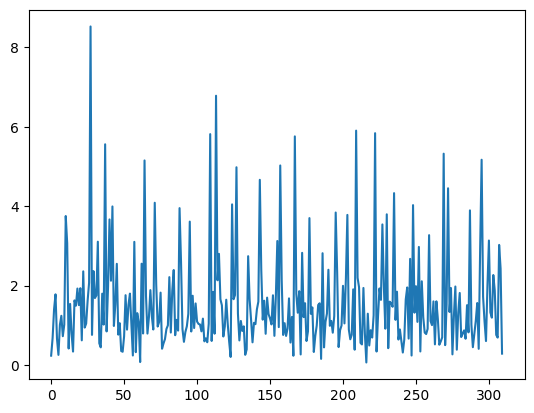

In [73]:
plt.plot(lossVals)